## [1] Import Libraries

In [7]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import rasterio as rio
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## [2] Set Up Masks

This sections creates masks for the MEASURES 2012-2013 mosaic no data regions, so that we can mask these out of the strain rate data which would otherwise have strange edge effects where the velocity data stops existing. 

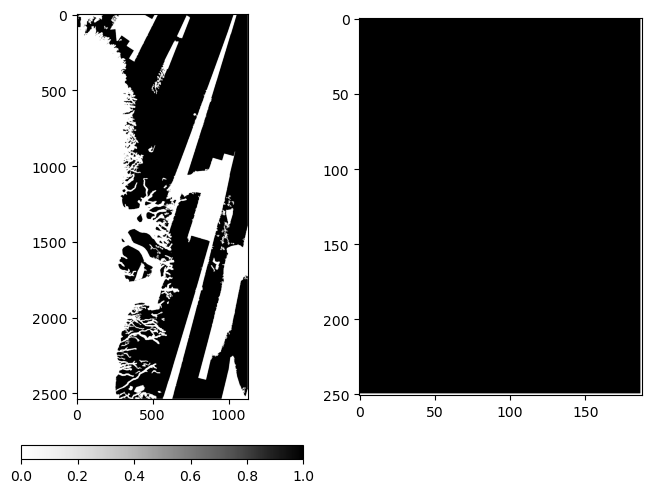

In [2]:
# Directories with velocities for training areas on the west coast of Greenland
vel_file_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\Velocity\\greenland_vel_mosaic500_2012_2013_vx_training.tif"
vel_file_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\Velocity\\greenland_vel_mosaic500_2012_2013_vx_NE.tif"

# Load the M12 velocity file for the west coast of Greenland and generate a mask to remove areas where the velocity data is not valid
dataset = rio.open(vel_file_w)
M12_velocity = dataset.read(1)
dataset.close()
vel_mask_w = np.zeros(M12_velocity.shape)
for i in range(0,vel_mask_w.shape[0]):
    for j in range(0,vel_mask_w.shape[1]):
        if M12_velocity[i,j] != -2e9:
            vel_mask_w[i,j] = 1.

# Load the M12 velocity file for the east coast of Greenland and generate a mask to remove areas where the velocity data is not valid
dataset = rio.open(vel_file_e)
M12_velocity = dataset.read(1)
dataset.close()
vel_mask_e = np.zeros(M12_velocity.shape)
for i in range(0,vel_mask_e.shape[0]):
    for j in range(0,vel_mask_e.shape[1]):
        if M12_velocity[i,j] != -2e9:
            vel_mask_e[i,j] = 1.

# Plot velocity masks for a sanity check
fig, (ax1, ax2) = plt.subplots(1,2,layout="constrained")
im = ax1.imshow(vel_mask_w, cmap='Greys')
ax2.imshow(vel_mask_e, cmap='Greys')
cbar = fig.colorbar(im, location='bottom')
plt.show()

## [3] Calculate Stress for Each Data Point

This code block calculates the principal stresses for each grid cell where we have an observation of crevasses or no crevasses and saves the results for plotting in the principal stress plane. 

In [2]:
# Directories with the strain rates
strain_dir_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRate\\"
strain_dir_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRateNE\\"
# Directory with the surface temperatures
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\RACMOTraining\\"
# Directory with the crevasse/no crevasse observations
crev_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TrainingData\\"
# Directory with the boundaries of the test data that we will withold from training
test_dir =  "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"

# Parameters for calculating stress that we determined to be optimal
# Exp18 - smoothing with a Gaussian filter with 1000 m bandwidth
strain_experiments = ["Exp18"]
velocity_maps = ["MAvg"]
temp_maps = ["Annual"]

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

for i in velocity_maps:
    for j in strain_experiments:
        # Set file locations for the strain rate for the west coast
        eXX_file_w = strain_dir_w+j+"_eXX_"+i+".tif"
        eYY_file_w = strain_dir_w+j+"_eYY_"+i+".tif"
        eXY_file_w = strain_dir_w+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the west coast
        dataset = rio.open(eXX_file_w)
        eXX_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_w)
        eYY_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_w)
        eXY_w = dataset.read(1)
        dataset.close()

        # Set file locations for the strain rate for the east coast
        eXX_file_e = strain_dir_e+j+"_eXX_"+i+".tif"
        eYY_file_e = strain_dir_e+j+"_eYY_"+i+".tif"
        eXY_file_e = strain_dir_e+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the east coast
        dataset = rio.open(eXX_file_e)
        eXX_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_e)
        eYY_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_e)
        eXY_e = dataset.read(1)
        dataset.close()

        # Mask out regions of no data in the 2012-2013 strain rate maps
        if i == "M12":
            eXX_w = eXX_w*vel_mask_w
            eYY_w = eYY_w*vel_mask_w
            eXY_w = eXY_w*vel_mask_w
            eXX_e = eXX_e*vel_mask_e
            eYY_e = eYY_e*vel_mask_e
            eXY_e = eXY_e*vel_mask_e

        for k in temp_maps:
            # Find the desired temperature field and crevasse observation masks
            # at the appropriate resolution to match the strain rate data
            if i == "MAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_250m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_250m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_250m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_250m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_250m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_250m.tif"
            elif i == "M12":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_500m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_500m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_500m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_500m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_500m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_500m.tif"
            elif i == "ILAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_240m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_240m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_240m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_240m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_240m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_240m.tif"

            # Load data for the west coast temperature filed
            dataset = rio.open(temp_file_w)
            temp_w = dataset.read(1)
            dataset.close()
            # Load crevasse mask for west coast
            dataset = rio.open(crev_file_w)
            crevasses_w = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for west coast
            dataset = rio.open(nocrev_file_w)
            no_crevasses_w = dataset.read(1)
            dataset.close()

            # Load data for the east coast temperature field
            dataset = rio.open(temp_file_e)
            temp_e = dataset.read(1)
            dataset.close()
            # Load crevasse mask for east coast
            dataset = rio.open(crev_file_e)
            crevasses_e = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for east coast
            dataset = rio.open(nocrev_file_e)
            no_crevasses_e = dataset.read(1)
            dataset.close()

            # Flatten data from a 2D map into a 1D vector for all datasets, then merge data from east and west training areas 
            # into a single vector for each variable
            crevasses_w = np.matrix.flatten(crevasses_w.astype("float64"))
            crevasses_e = np.matrix.flatten(crevasses_e.astype("float64"))
            crevasses = np.concatenate((crevasses_w, crevasses_e), axis=0)
            no_crevasses_w = np.matrix.flatten(no_crevasses_w.astype("float64"))
            no_crevasses_e = np.matrix.flatten(no_crevasses_e.astype("float64"))
            no_crevasses = np.concatenate((no_crevasses_w, no_crevasses_e), axis=0)

            # Combine flattened strain rate matrices for both regions (east and west)
            eXX_comb = np.concatenate((np.matrix.flatten(eXX_w), np.matrix.flatten(eXX_e)), axis=0)
            eXY_comb = np.concatenate((np.matrix.flatten(eXY_w), np.matrix.flatten(eXY_e)), axis=0)
            eYY_comb = np.concatenate((np.matrix.flatten(eYY_w), np.matrix.flatten(eYY_e)), axis=0)

            # Combine flattened temperature information for both regions (east and west)
            temp_comb = np.concatenate((np.matrix.flatten(temp_w), np.matrix.flatten(temp_e)), axis=0)

            # Extract strain rates in crevassed and uncrevassed regions
            eXX_crev = eXX_comb[crevasses == 1]
            eXX_nocrev = eXX_comb[no_crevasses == 1]
            eXY_crev = eXY_comb[crevasses == 1]
            eXY_nocrev = eXY_comb[no_crevasses == 1]
            eYY_crev = eYY_comb[crevasses == 1]
            eYY_nocrev = eYY_comb[no_crevasses == 1]

            # Extract temperatures for crevassed and uncrevassed regions
            temp_crev = temp_comb[crevasses == 1]
            temp_nocrev = temp_comb[no_crevasses == 1]

            # Merge into a single vectors for all variables of interest
            eXX = np.concatenate((eXX_crev, eXX_nocrev), axis=0)
            eXY = np.concatenate((eXY_crev, eXY_nocrev), axis=0)
            eYY = np.concatenate((eYY_crev, eYY_nocrev), axis=0)
            temp = np.concatenate((temp_crev,  temp_nocrev), axis=0)

            # Convert temperature field to degrees Kelvin
            temp = temp + 273.15

            # Calculate creep coefficient with temperature dependence of activation energy on west coast
            A = np.zeros(temp.shape)
            for p in range(0,temp.shape[0]):
                if temp[p] > 273.15:
                    temp[p] = 273.15
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                elif temp[p] > 263.0:
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                else:
                    A[p] = A_star*np.exp((-Qc/R)*((1/temp[p]) - (1/T_start)))

            # Convert strain rates from 1/yr to 1/s
            eXX_s = eXX*(1/(60*60*24*365))
            eXY_s = eXY*(1/(60*60*24*365))
            eYY_s = eYY*(1/(60*60*24*365))

            #Calculate effective stress
            eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)

            # Calculate deviatoric stress at surface
            tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
            tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
            tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s 

            # Calculate full Cauchy stress at surface
            sigma_xx = 2.*tau_xx + tau_yy
            sigma_yy = 2.*tau_yy + tau_xx

            # Calculate principal stresses
            sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
            sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)

            # Make the label set (1 = crevassed, 0 = not crevassed)
            label = np.concatenate((np.ones(temp_crev.shape), np.zeros(temp_nocrev.shape)), axis=0)

            # Create four output vectors with the minimum and maximum principal stress for crevassed and uncrevassed regions
            sigma1_crev = sigma1[label == 1]
            sigma1_nocrev = sigma1[label == 0]
            sigma2_crev = sigma2[label == 1]
            sigma2_nocrev = sigma2[label == 0]
            
            print("All done!")


All done!


## [4] Plot Figure 2a

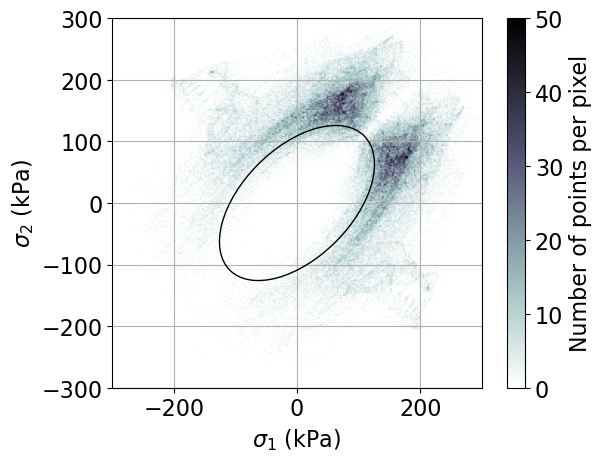

In [5]:
# Remove any nan values that might be lurking in that data and concatenate to make plotting easier
sigma1_crev_clean = sigma1_crev[~np.isnan(sigma1_crev)]
sigma2_crev_clean = sigma2_crev[~np.isnan(sigma1_crev)]
crev1 = np.concatenate((sigma1_crev_clean, sigma2_crev_clean))
crev2 = np.concatenate((sigma2_crev_clean, sigma1_crev_clean))

# Calculate parameters to draw an ellipse representing a von Mises stress envelope of 109 kPa
A = 1
B = -1
C = 1
D = 0
E = 0
F = -109**2
a = -np.sqrt(2*(A*E**2+C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C)+np.sqrt((A-C)**2 + B**2)))/(B**2 - 4*A*C)
b = -np.sqrt(2*(A*E**2+C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C)-np.sqrt((A-C)**2 + B**2)))/(B**2 - 4*A*C)
ellipse = Ellipse(xy=(0,0), width=2*a, height=2*b, angle=45,
                        edgecolor='k', fc='None', lw=1)

# Update the plot font size for vetter legibility
plt.rcParams.update({'font.size': 16})

# Plot the figure
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection="scatter_density")
density = ax.scatter_density(crev1/1000, crev2/1000, cmap='bone_r', vmin=0, vmax=50)
ax.add_patch(ellipse)
plt.xlabel("$\sigma_{1}$ (kPa)")
plt.ylabel("$\sigma_{2}$ (kPa)")
fig.colorbar(density, label='Number of points per pixel')
plt.xlim((-300, 300))
plt.ylim((-300, 300))
#plt.set_aspect(1)
plt.grid()
plt.gca().set_axisbelow(True)
ax.set_aspect('equal', adjustable='box')
#plt.savefig("./Figures/CrevasseDonut.svg", format='svg', dpi=300)
plt.show()

## [5] Plot Figure 2b

Note: must be run after you have successfully run Section 4 where the ellipse parameters are defined.

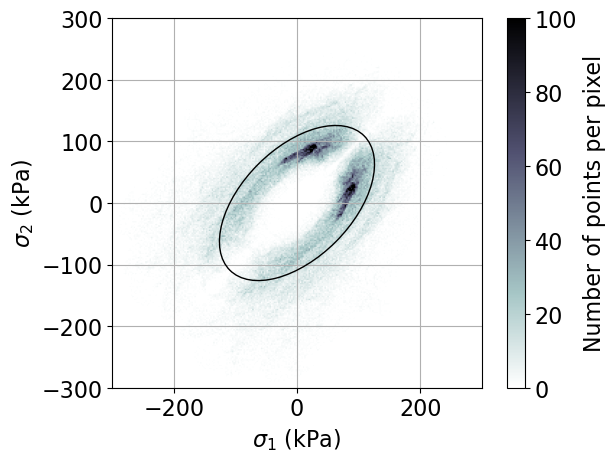

In [6]:
# Remove any lurking nans and concatenate results to make plotting easier 
# Note this is equivalent to assuming that the data will be symmetric across the 1:1 line
sigma1_nocrev_clean = sigma1_nocrev[~np.isnan(sigma1_nocrev)]
sigma2_nocrev_clean = sigma2_nocrev[~np.isnan(sigma1_nocrev)]
nocrev1 = np.concatenate((sigma1_nocrev_clean, sigma2_nocrev_clean))
nocrev2 = np.concatenate((sigma2_nocrev_clean, sigma1_nocrev_clean))

# Generate von Mises ellipse
ellipse = Ellipse(xy=(0,0), width=2*a, height=2*b, angle=45,
                        edgecolor='k', fc='None', lw=1)

# Plot the figures
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection="scatter_density")
density = ax.scatter_density(nocrev1/1000, nocrev2/1000, cmap="bone_r", vmin=0, vmax=100)
plt.xlabel("$\sigma_{1}$ (kPa)")
plt.ylabel("$\sigma_{2}$ (kPa)")
ax.add_patch(ellipse)
plt.xlim((-300, 300))
plt.ylim((-300, 300))
fig.colorbar(density, label='Number of points per pixel')
plt.grid()
plt.gca().set_axisbelow(True)
ax.set_aspect('equal', adjustable='box')
#plt.savefig("./Figures/NoCrevasseDonut.svg", format='svg', dpi=300)
#plt.set_aspect(1)
plt.show()

## [6] Plot Figure 2c

Note that you need to first run `c_CalculateFractureOrientation.mat` if you do not have a file called `FractureOrientation.csv` already. 

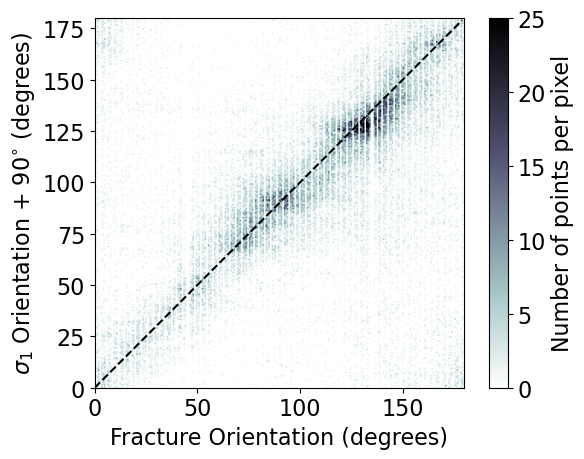

In [10]:
orientation = pd.read_csv("data/FractureOrientation.csv")

plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection="scatter_density")
density = ax.scatter_density(orientation['Fracture'], orientation['Stress'], cmap='bone_r', vmin=0, vmax=25)
ax.plot(np.arange(0,180,1), np.arange(0,180,1), 'k', linestyle="--")
plt.xlabel("Fracture Orientation (degrees)")
plt.ylabel("$\sigma_1$ Orientation + 90$^{\circ}$ (degrees)")
ax.set_xlim((0,180))
ax.set_ylim((0,180))
fig.colorbar(density, label='Number of points per pixel')
ax.set_aspect('equal', adjustable='box')
#plt.savefig("./Figures/FractureOrientation.svg", format='svg', dpi=300)
plt.show()